In [136]:
import pandas as pd
import numpy as np
import re
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import spacy

In [2]:
df = pd.read_csv('job_data.csv')

In [3]:
df.head()

,company,job_title,location,salary,company_size,company_founded,company_type,company_industry,company_sector,company_revenue,job_description
0,Bluefin Resources4.0 ★,EMPO Reporting Analyst,Sydney,"$120,000",51 to 200 Employees,--,Company - Private,--,--,Unknown / Non-Applicable,Bluefin Resources are seeking an experienced P...
1,Macquarie Group Limited4.0 ★,Junior Data Business Analyst | Commodities and...,Sydney,"$108,167",10000+ Employees,1969,Company - Public,Investment & Asset Management,Finance,$5 to $10 billion (USD),We are a dynamic change team who works collabo...
2,ETM Group Holdings Pty Ltd,Business Analyst,Alexandria,"$90,000",NaN,NaN,NaN,NaN,NaN,NaN,ETM Group Holdings is currently searching for ...
3,Nixil4.0 ★,Junior Data Analyst: Investment Data Managemen...,Sydney,$0,Unknown,--,Company - Private,--,--,Unknown / Non-Applicable,Work options: Hybrid Our client is seeking a d...
4,TPG Telecom4.0 ★,Data & Reporting Analyst,North Sydney,"$78,772",1001 to 5000 Employees,2020,Company - Public,"Cable, Internet & Telephone Providers",Telecommunications,$2 to $5 billion (USD),Exciting time to join a top 100 ASX listed bus...


In [4]:
df.columns

Index(['company', 'job_title', 'location', 'salary', 'company_size',
       'company_founded', 'company_type', 'company_industry', 'company_sector',
       'company_revenue', 'job_description'],
      dtype='object')

In [5]:
# Dropping all columns aside from job title and description
df.drop(['company', 'location', 'salary', 'company_size',
       'company_founded', 'company_type', 'company_industry', 'company_sector',
       'company_revenue'], axis=1, inplace=True)

Analysing most common words in job titles

In [6]:
job_titles_words = {}

for job_title in df['job_title']:
    for word in job_title.lower().split():
        if word in job_titles_words:
            job_titles_words[word] += 1
        else:
            job_titles_words[word] = 1

In [7]:
sorted_job_titles_words = sorted(job_titles_words.items(), key=lambda item: item[1])

In [8]:
sorted_job_titles_words

[('empo', 1),
 ('gls', 1),
 ('operation', 1),
 ('schedule', 1),
 ('visa', 1),
 ('natural', 1),
 ('hazards', 1),
 ('analytics-business', 1),
 ('managed', 1),
 ('portfolios', 1),
 ('3-4', 1),
 ('days', 1),
 ('from', 1),
 ('home!', 1),
 ('trainer', 1),
 ('success', 1),
 ('analyst/data', 1),
 ('kyc', 1),
 ('(hse)', 1),
 ('+', 1),
 ('ext.', 1),
 ('(centre', 1),
 ('video', 1),
 ('analyst/engineer', 1),
 ('chapter', 1),
 ('cdao', 1),
 ('owner/senior', 1),
 ('premium', 1),
 ('underwriting', 1),
 ('consultant/analyst', 1),
 ('rewards', 1),
 ('methods', 1),
 ('leasing', 1),
 ('structured', 1),
 ('ratings,', 1),
 ('(mysql)', 1),
 ('the', 1),
 ('office!', 1),
 ('government', 1),
 ('+...', 1),
 ('(it', 1),
 ('contracts', 1),
 ('manager)', 1),
 ('cappitech', 1),
 ('trade', 1),
 ('pos/cb', 1),
 ('(new', 1),
 ('healthcare', 1),
 ('company)', 1),
 ('network', 1),
 ('3p', 1),
 ('last', 1),
 ('mile', 1),
 ('opportunity', 1),
 ('horsley', 1),
 ('park', 1),
 ('developer:', 1),
 ('architecture', 1),
 ('(qli

Processing the job descriptions:

In [9]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alexs\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexs\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alexs\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
# Handling NaN values
df['job_description'].isna().sum()
df.dropna(inplace=True)

2

In [12]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

In [13]:
df['processed_job_description'] = df['job_description'].apply(preprocess_text)

In [14]:
df['processed_job_description']

0       bluefin resource seeking experienced project r...
1       dynamic change team work collaboratively withi...
2       etm group holding currently searching firstrat...
3       work option hybrid client seeking dedicated in...
4       exciting time join top 100 asx listed business...
                              ...                        
1318    flexible work arrangement meet need work cutti...
1319    edx part 2u inc work respected university orga...
1320    flexible work arrangement meet need work cutti...
1321    phd project supervised knowledgeguided machine...
1322    opportunity join pinnacle academic excellence ...
Name: processed_job_description, Length: 1321, dtype: object

Extracting the years of experience required

In [15]:
# Function using regex to extract years of experience from job descriptions
def extract_years_of_experience(description):
    pattern = r'(\d+(?:\+\s*)?)(?:-|to)?\s*(\d+)?\s*(?:years|year|yrs|yr)\b'
    matches = re.findall(pattern, description, flags=re.IGNORECASE)
    return ["-".join(filter(None, match)) for match in matches]

In [16]:
df['years_of_experience'] = df['job_description'].apply(extract_years_of_experience)

In [17]:
df['years_of_experience']

0         [3-5]
1       [54, 2]
2            []
3            []
4            []
         ...   
1318         []
1319        [5]
1320         []
1321     [5, 5]
1322         []
Name: years_of_experience, Length: 1321, dtype: object

In [18]:
# Function to parse and calculate the average years of experience from 'years_of_experience' strings
# Assumed almost no positions would be asking for > 15 yrs experience explicitly
def parse_and_average_years(year_strings):
    years = []
    for year_string in year_strings:
        # Skip empty strings
        if not year_string.strip():
            continue
        # Check for presence of '+' indicating 5+ years, interpret as 5
        if '+' in year_string:
            year = float(year_string.replace('+', '').strip())
            if year < 15:
                years.append(year)
        # Check for a range like '3-5'
        elif '-' in year_string:
            range_years = year_string.split('-')
            # Convert all to float and calculate average if both are less than 15
            range_years = [float(y) for y in range_years if float(y) < 15]
            if range_years:
                years.append(sum(range_years) / len(range_years))
        # It's just a number, no range
        else:
            year = float(year_string.strip())
            if year < 15:
                years.append(year)
    # Return the average of the years, or NaN if empty
    return np.mean(years) if years else np.nan

# Apply the function to calculate the average years of experience
df['average_years_of_experience'] = df['years_of_experience'].apply(parse_and_average_years)

In [19]:
df['average_years_of_experience']

0       4.0
1       2.0
2       NaN
3       NaN
4       NaN
       ... 
1318    NaN
1319    5.0
1320    NaN
1321    5.0
1322    NaN
Name: average_years_of_experience, Length: 1321, dtype: float64

In [28]:
df['average_years_of_experience'].mean()

4.113194444444445

In [30]:
df.rename(columns={'average_years_of_experience': 'avg_yrs_exp'}, inplace=True)

In [34]:
df['avg_yrs_exp'] = df['avg_yrs_exp'].apply(lambda x: round(x, 2))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 [Text(0, 0, '1.0'),
  Text(1, 0, '1.5'),
  Text(2, 0, '2.0'),
  Text(3, 0, '2.12'),
  Text(4, 0, '2.25'),
  Text(5, 0, '2.5'),
  Text(6, 0, '2.67'),
  Text(7, 0, '2.75'),
  Text(8, 0, '3.0'),
  Text(9, 0, '3.25'),
  Text(10, 0, '3.5'),
  Text(11, 0, '4.0'),
  Text(12, 0, '4.2'),
  Text(13, 0, '4.25'),
  Text(14, 0, '4.33'),
  Text(15, 0, '4.5'),
  Text(16, 0, '5.0'),
  Text(17, 0, '5.5'),
  Text(18, 0, '6.0'),
  Text(19, 0, '6.25'),
  Text(20, 0, '6.5'),
  Text(21, 0, '6.67'),
  Text(22, 0, '7.0'),
  Text(23, 0, '7.5'),
  Text(24, 0, '8.0'),
  Text(25, 0, '8.5'),
  Text(26, 0, '9.0'),
  Text(27, 0, '10.0')])

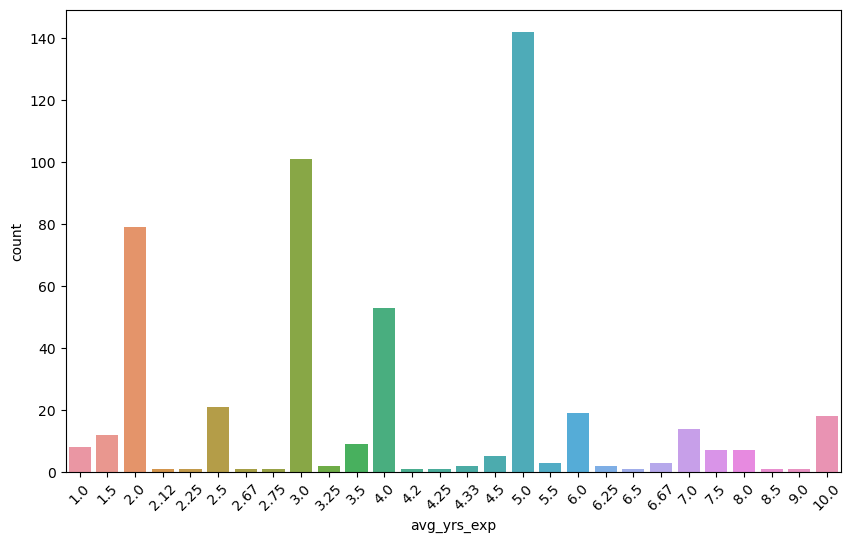

In [37]:
# Display the frequency of yrs of experience required across jobs
plt.figure(figsize=(10,6))
sns.countplot(df, x='avg_yrs_exp')
plt.xticks(rotation=45)

Extracting skills

In [76]:
skills_list = ['python', 'r', 'java', 'scala', 'julia', 'statistics', 'statistical', 'wrangling', 'visualization', 'visualisation', 
               'tableau', 'power bi', 'bi', 'qlikview', 'ggplot2', 'matplotlib', 'seaborn', 'mysql', 'postgresql', 'mongodb',
               'hadoop', 'cassandra', 'machine learning', 'database', 'supervised learning', 'unsupervised learning',
               'nlp', 'natural language processing', 'deep learning', 'validation', 'big data', 'apache', 'spark', 'flink', 'storm',
               'amazon redshift', 'google bigquery', 'snowflake', 'business analysis', 'reporting', 'etl', 'pipeline',
               'workflow', 'cloud', 'aws', 'azure', 'git', 'svn', 'sql']
pattern = r'\b(?:' + '|'.join(re.escape(skill) for skill in skills_list) + r')\b'
df['skills'] = df['processed_job_description'].str.findall(pattern, flags=re.IGNORECASE)

In [77]:
df['skills']

0            [reporting, reporting, reporting, reporting]
1                                                      []
2                                    [workflow, workflow]
3                [python, r, sql, visualization, tableau]
4       [reporting, reporting, reporting, power bi, re...
                              ...                        
1318    [cloud, natural language processing, nlp, deep...
1319    [big data, python, python, matplotlib, databas...
1320    [cloud, cloud, azure, aws, natural language pr...
1321    [machine learning, machine learning, machine l...
1322    [statistical, statistical, machine learning, s...
Name: skills, Length: 1321, dtype: object

In [78]:
# Convert the skills lists into sets to remove duplicates
df['skills'] = df['skills'].apply(lambda x: set(x))

In [79]:
skill_counts = df['skills'].explode().value_counts()
skill_counts

skills
reporting                      633
sql                            421
python                         265
power bi                       229
database                       211
visualisation                  174
statistical                    174
tableau                        166
r                              165
business analysis              156
machine learning               149
cloud                          133
bi                             127
workflow                       110
visualization                   88
azure                           85
aws                             82
pipeline                        71
validation                      63
etl                             62
big data                        47
snowflake                       34
deep learning                   32
spark                           32
java                            22
nlp                             20
hadoop                          20
git                             16
natural langu

In [80]:
# Adding the visualization counts to the visualisation count
skill_counts.loc['visualisation'] += skill_counts.loc['visualization']
skill_counts.drop('visualization', inplace=True)
skill_counts = skill_counts.sort_values(ascending=False)

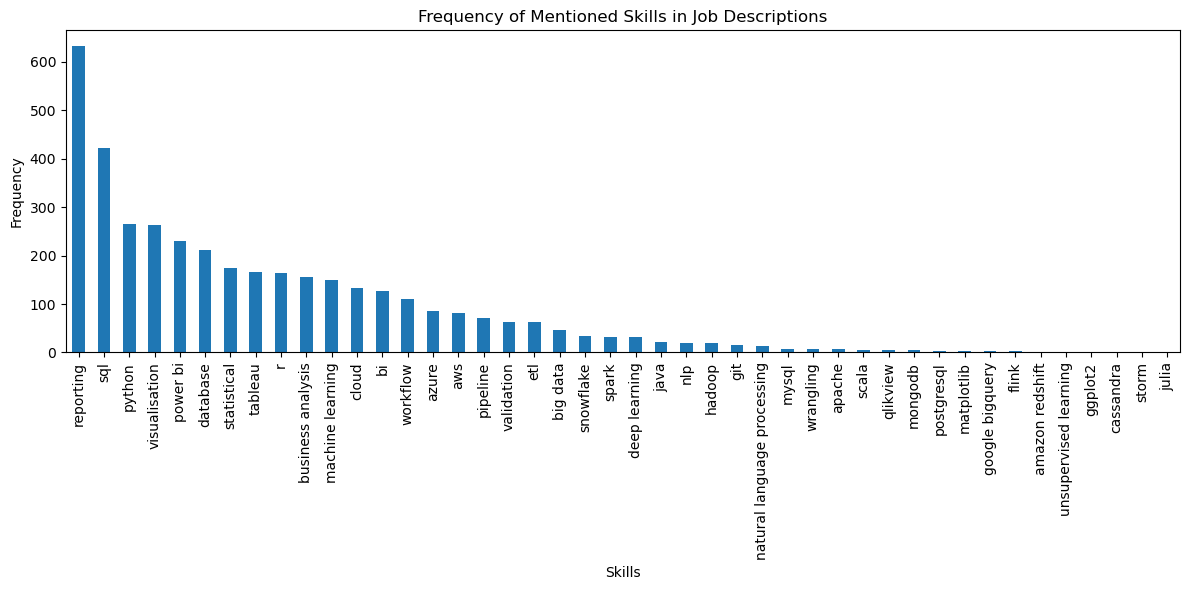

In [122]:
# Plotting the freqency of required skills
plt.figure(figsize=(12, 6))
skill_counts.plot(kind='bar')
plt.title('Frequency of Mentioned Skills in Job Descriptions')
plt.xlabel('Skills')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.tight_layout()

(-0.5, 799.5, 399.5, -0.5)

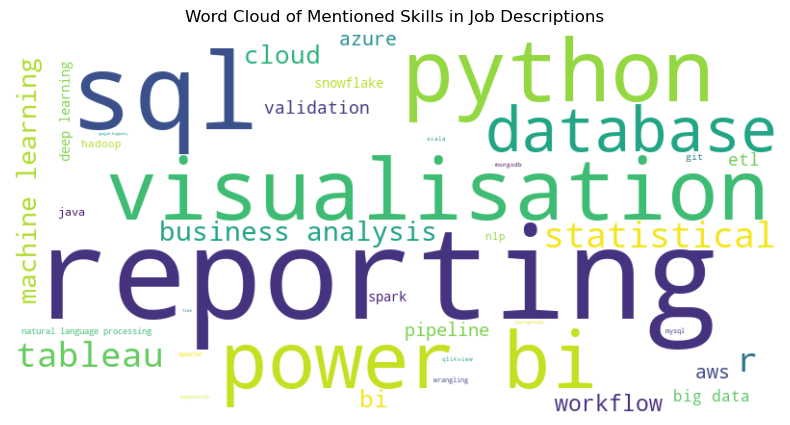

In [134]:
# Create a WordCloud object with required skills
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(skill_counts)

# Display the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Mentioned Skills in Job Descriptions')
plt.axis('off')

Using Named Entitiy Recognition to identify skills and degrees.

In [143]:
nlp = spacy.load("en_core_web_md")

In [149]:
# Function to perform Named Entity Recognition (NER)
def extract_entities(text):
    # Use spaCy's NLP pipeline to perform NER
    doc = nlp(text)
    skills = []
    degrees = []
    # Extract entities specific to job descriptions such as skills and degrees using the org, product and degree NER labels
    for ent in doc.ents:
        if ent.label_ in ('ORG', 'PRODUCT'):
            skills.append(ent.text)
        elif ent.label_ == 'DEGREE':
            degrees.append(ent.text)
    return skills, degrees

In [152]:
# Applying the extract_entities function to the processed_job_description column and greating two new columns
df['Skills'], df['Degrees'] = zip(*df['processed_job_description'].apply(extract_entities))

In [153]:
skills_frequency = pd.Series(sum([skills for skills in df['Skills']], [])).value_counts()
degrees_frequency = pd.Series(sum([degrees for degrees in df['Degrees']], [])).value_counts()

(-0.5, 799.5, 399.5, -0.5)

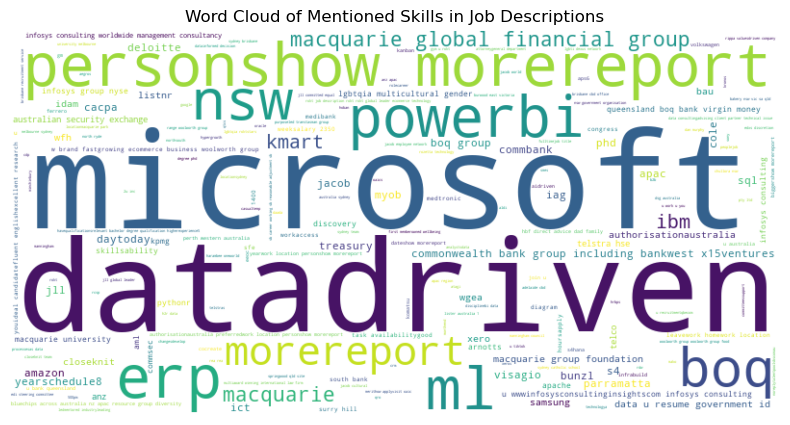

In [157]:
# Create a WordCloud object with NER skills
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(skills_frequency)

# Display the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Mentioned Skills in Job Descriptions')
plt.axis('off')

Applying the same approach to soft skills

In [164]:
soft_skills_list = ["analytical thinking", "problem-solving", "critical thinking", "creativity",
               "attention detail", "communication", "teamwork", "collaboration",
               "adaptability", "emotional intelligence", "time management", "project management",
               "leadership", "initiative", "curiosity", "perseverance", "resilience", "resourcefulness",]

In [165]:
pattern = r'\b(?:' + '|'.join(re.escape(skill) for skill in soft_skills_list) + r')\b'
df['soft_skills'] = df['processed_job_description'].str.findall(pattern, flags=re.IGNORECASE)

In [166]:
# Convert the skills lists into sets to remove duplicates
df['soft_skills'] = df['soft_skills'].apply(lambda x: set(x))

In [167]:
soft_skill_counts = df['soft_skills'].explode().value_counts()
soft_skill_counts

soft_skills
communication             784
initiative                421
leadership                220
collaboration             214
attention detail          201
project management        145
time management            69
creativity                 54
curiosity                  53
critical thinking          51
teamwork                   43
resilience                 33
adaptability               29
analytical thinking         8
resourcefulness             6
emotional intelligence      1
Name: count, dtype: int64

In [169]:
soft_skill_counts = soft_skill_counts.rename({'attention detail': 'attention to detail'})

(-0.5, 799.5, 399.5, -0.5)

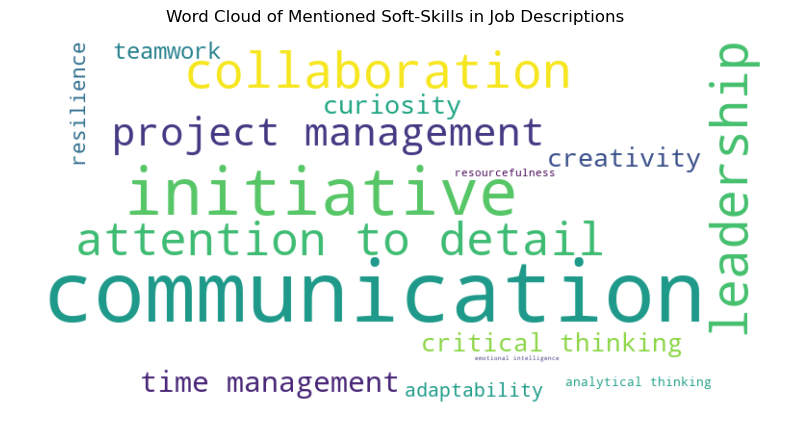

In [173]:
# Create a WordCloud object with the sof_skills list
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(soft_skill_counts)

# Display the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Mentioned Soft-Skills in Job Descriptions')
plt.axis('off')

Looking for key phrases

In [174]:
# TF-IDF Vectorizer to find key phrases
vectorizer = TfidfVectorizer(ngram_range=(2, 3), max_features=100)
X = vectorizer.fit_transform(df['processed_job_description'])
features = vectorizer.get_feature_names_out()

<Axes: xlabel='term'>

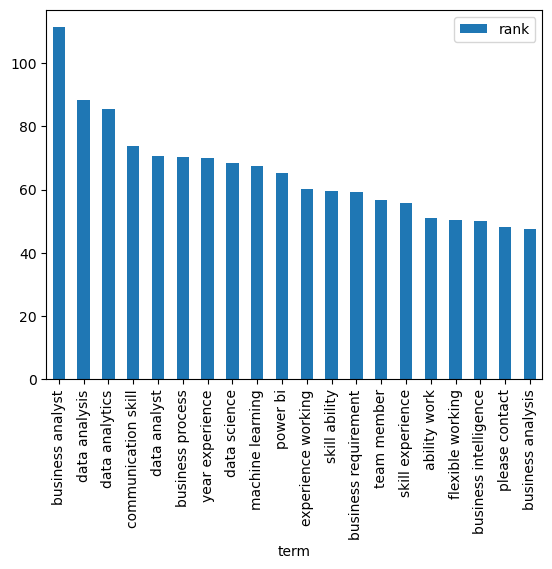

In [176]:
# Plotting the most common bigrams/trigrams
sums = X.sum(axis=0)
data = []
for col, term in enumerate(features):
    data.append((term, sums[0, col]))
ranking = pd.DataFrame(data, columns=['term', 'rank'])
ranking.sort_values('rank', ascending=False, inplace=True)
ranking[:20].plot(kind='bar', x='term', y='rank')

In [178]:
# Complete list of the most common terms within job descriptions
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(ranking)

                            term        rank
12              business analyst  111.283161
26                 data analysis   88.453187
28                data analytics   85.412086
20           communication skill   73.697160
27                  data analyst   70.686373
15              business process   70.491450
99               year experience   70.024655
31                  data science   68.458604
60              machine learning   67.553185
70                      power bi   65.176003
44            experience working   60.110114
81                 skill ability   59.454066
16          business requirement   59.331681
89                   team member   56.611428
82              skill experience   55.633974
0                   ability work   50.966123
47              flexible working   50.346733
13         business intelligence   50.257533
68                please contact   48.312256
11             business analysis   47.591709
7               attention detail   47.202168
43        

In [179]:
df.to_csv('job_data_NLP.csv', index = False)